# Pitching EDA — Pitch-level focused analysis

This notebook analyzes the pitch-by-pitch Statcast from `data/raw/statcast_*.parquet` via `src.data.statcast_loader.load_raw_statcast`, computes correct:
- innings pitched per appearance,
- total pitches thrown per appearance,
- times-through-order (TTO) from pitch-level fields,

and then reproduces the EDA visuals (histograms, overlays, ridge plots, faceted distributions, pitcher profiles, and heatmaps).  
All saved figures are written to `viz/` in the src directory.

## Setup: imports, path handling, viz folder

In [27]:
# Setup: imports, path, and viz folder
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Adjust project_root if needed. 
# If this notebook is under project_root/notebooks/, project_root is parent directory:
project_root = os.path.abspath("..")   # change this line if your notebook is elsewhere
sys.path.append(project_root)

# Ensure viz folder exists
viz_folder = "../src/viz"
os.makedirs(viz_folder, exist_ok=True)

print("Project root:", project_root)
print("Viz folder:", os.path.abspath(viz_folder))

Project root: c:\Users\Matth\OneDrive\Desktop\CS3346\MLB-Bullpen-Strategy
Viz folder: c:\Users\Matth\OneDrive\Desktop\CS3346\MLB-Bullpen-Strategy\src\viz


## Import loader and load raw pitch data

In [28]:
# Import the loader and load pitch-by-pitch statcast for 2022 and 2023
# Note: statcast_loader.load_raw_statcast concatenates raw statcast_YYYY_MM.parquet files.

try:
    from src.data.statcast_loader import load_raw_statcast
except Exception as e:
    raise ImportError(
        "Could not import load_raw_statcast from src.data.statcast_loader. "
        "Check project_root and that src/data/statcast_loader.py exists."
    ) from e

# Load 2022 & 2023
years = [2022, 2023]
print(f"Loading raw statcast for years: {years} ... (this may take a moment)")
df = load_raw_statcast(years)
print("Loaded rows:", len(df))

Loading raw statcast for years: [2022, 2023] ... (this may take a moment)
Loaded rows: 1547975


## Basic inspection and column confirmation

In [29]:
# quick sanity checks
pd.set_option("display.max_columns", 120)
print("Columns (sample):", df.columns.tolist()[:40])
print("Unique years:", df['game_year'].unique()[:10])
df.head()

Columns (sample): ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated']
Unique years: <IntegerArray>
[2022, 2023]
Length: 2, dtype: Int64


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2022-04-26,90.6,-1.94,6.53,"McKenzie, Triston",621493,663474,None,called_strike,<NA>,<NA>,<NA>,<NA>,8,Called Strike,R,R,R,LAA,CLE,S,<NA>,None,0,0,2022,-0.18,1.68,-0.01,1.97,<NA>,<NA>,<NA>,0,1,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.263925,-131.624892,-9.064997,-3.296912,29.577631,-10.913467,3.35,1.59,<NA>,<NA>,<NA>,91.1,2192,6.8,661032,595978,680911,665926,608070,642708,676391,664702,640458,53.66,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,192,-0.001,-0.038,<NA>,<NA>,<NA>,0.038,<NA>,0,0,0.548109,0.548109,24,28,25,29,1,0,6,1,5,1,1.12,0.18,0.18,53.2,<NA>,<NA>,<NA>,<NA>,<NA>
1,FF,2022-04-26,92.6,-1.9,6.39,"McKenzie, Triston",621493,663474,None,called_strike,<NA>,<NA>,<NA>,<NA>,6,Called Strike,R,R,R,LAA,CLE,S,<NA>,None,0,1,2022,-0.2,1.67,0.66,2.62,<NA>,<NA>,<NA>,0,1,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.049281,-134.513701,-7.483133,-4.034894,30.300535,-10.495477,3.53,1.7,<NA>,<NA>,<NA>,93.4,2209,6.9,661032,595978,680911,665926,608070,642708,676391,664702,640458,53.57,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,2,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,196,-0.001,-0.051,<NA>,<NA>,<NA>,0.051,<NA>,0,0,0.548109,0.548109,24,28,25,29,1,0,6,1,5,1,1.01,0.2,0.2,48.9,<NA>,<NA>,<NA>,<NA>,<NA>
2,FF,2022-04-26,93.0,-2.04,6.42,"McKenzie, Triston",621493,663474,None,foul,<NA>,<NA>,<NA>,<NA>,1,Foul,R,R,R,LAA,CLE,S,<NA>,None,0,2,2022,-0.39,1.71,-0.75,2.88,<NA>,<NA>,<NA>,0,1,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.181289,-135.298538,-7.083171,-5.752503,30.740898,-9.833717,3.35,1.61,181,64.5,44,93.6,2197,6.8,661032,595978,680911,665926,608070,642708,676391,664702,640458,53.73,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,3,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,195,-0.001,0.0,<NA>,<NA>,<NA>,0.0,88.0,0,0,0.548109,0.548109,24,28,25,29,1,0,6,1,5,1,0.94,0.39,0.39,50.1,<NA>,<NA>,<NA>,<NA>,<NA>
3,FF,2022-04-26,92.2,-1.97,6.43,"McKenzie, Triston",621493,663474,None,foul,<NA>,<NA>,<NA>,<NA>,11,Foul,R,R,R,LAA,CLE,S,<NA>,None,0,2,2022,-0.17,1.65,-0.62,3.72,<NA>,<NA>,<NA>,0,1,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3.813845,-134.120965,-4.644824,-2.875292,30.510013,-11.497458,3.35,1.61,187,72.2,56,92.7,2188,6.7,661032,595978,680911,665926,608070,642708,676391,664702,640458,53.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,4,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,188,-0.001,0.0,<NA>,<NA>,<NA>,0.0,88.0,0,0,0.548109,0.548109,24,28,25,29,1,0,6,1,5,1,1.04,0.17,0.17,50.6,<NA>,<NA>,<N

## Standardize column names / helpful copies

In [30]:
# Normalize column names we will use (aliases to avoid confusion)
# raw columns (as you supplied) contain: 'pitcher', 'pitch_number', 'at_bat_number', 'outs_when_up',
# 'events', 'pitch_type', 'release_speed', 'n_thruorder_pitcher', 'game_pk', 'inning', etc.

# Use consistent names in this notebook
PITCHER_COL = "pitcher"
GAME_COL = "game_pk"
PITCH_NUM_COL = "pitch_number"
ATBAT_COL = "at_bat_number"
EVENT_COL = "events"
OUTS_WHEN_UP_COL = "outs_when_up"
INNING_COL = "inning"
TTO_RAW_COL = "n_thruorder_pitcher"  # pitch-level TTO if present
RELEASE_SPEED_COL = "release_speed"
PITCH_TYPE_COL = "pitch_type"

## 1. Compute outs per plate appearance (robust method)

In [31]:
# Determine whether an at-bat resulted in 0/1/2 outs by a simple event mapping.
# This mapping is conservative but handles the common cases including double plays.

# Lowercase events to standardize
df['events_clean'] = df[EVENT_COL].astype(str).str.lower()

# Define event tokens that indicate outs; double-play keywords treated as 2 outs
double_play_keywords = ["double play", "double_play", "dp"]
single_out_keywords = [
    "strikeout", "strikeout (looking)", "strikeout (swinging)", "groundout",
    "ground out", "flyout", "fly out", "lineout", "pop out", "play", "force out",
    "field out", "field_out", "fielders_choice_out", "sac fly", "sac_fly", "sacrifice",
    "pickoff", "caught_stealing", "caught stealing", "triple play"  # triple play unlikely but covered below
]

# We'll compute outs_per_pa with the following rules:
# - If event contains a double-play keyword -> 2
# - If event contains 'triple' -> 3
# - If event contains any single_out_keyword -> 1
# - else -> 0

def outs_from_event(ev: str) -> int:
    evl = ev.lower()
    if any(tok in evl for tok in double_play_keywords):
        return 2
    if "triple play" in evl or "triple_play" in evl:
        return 3
    if any(tok in evl for tok in single_out_keywords):
        return 1
    return 0

# Compute outs per pitch row then collapse to at-bat level (outs occur once per at-bat)
df['_outs_flag'] = df['events_clean'].apply(outs_from_event)

# Some datasets may repeat the same event across multiple pitch rows for the at-bat;
# compute outs_by_atbat per at-bat (only one value per at-bat)
outs_by_atbat = (
    df.groupby([GAME_COL, ATBAT_COL, PITCHER_COL])[['_outs_flag', OUTS_WHEN_UP_COL, INNING_COL]]
      .agg({'_outs_flag': 'max', OUTS_WHEN_UP_COL: 'first', INNING_COL: 'first'})
      .reset_index()
      .rename(columns={'_outs_flag': 'outs_in_pa'})
)

# Sanity check: show the distribution of outs_in_pa (0/1/2 mostly)
outs_by_atbat['outs_in_pa'].value_counts(dropna=False)

outs_in_pa
1    256843
0    142158
2      8790
3         7
Name: count, dtype: int64

## 2. Compute innings pitched per pitcher appearance

In [32]:
# Sum outs_in_pa for each pitcher-game to get outs recorded by that pitcher in that appearance
outs_per_pitcher_game = (
    outs_by_atbat.groupby([GAME_COL, PITCHER_COL])['outs_in_pa']
    .sum()
    .reset_index(name='outs_recorded')
)

# Convert to innings pitched
outs_per_pitcher_game['innings_pitched'] = outs_per_pitcher_game['outs_recorded'] / 3.0

# Rename for clarity (appearance-level summary)
pitcher_appear = outs_per_pitcher_game.rename(columns={
    PITCHER_COL: 'pitcher_id',
    GAME_COL: 'game_pk',
    'outs_recorded': 'outs_recorded_in_appearance',
    'innings_pitched': 'innings_before_pull'  # we will use this as the main innings metric
})

# Show sample
pitcher_appear.sort_values(['innings_before_pull'], ascending=False).head(10)

,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull
12279,662460,693821,27,9.0
871,661134,645261,27,9.0
25087,716413,543037,27,9.0
11574,662373,664285,27,9.0
19143,663261,543475,27,9.0
30294,717018,669923,27,9.0
28490,716803,502171,27,9.0
35051,717579,593334,27,9.0
44559,718714,645261,27,9.0
32249,717252,645261,27,9.0


## 3. Compute total pitches thrown per appearance

In [33]:
# Determine total pitches per pitcher-game by taking the max pitch_number for that pitcher-game
pitches_per_appearance = (
    df.groupby([GAME_COL, PITCHER_COL])[PITCH_NUM_COL]
    .max()
    .reset_index(name='total_pitches')
)

pitches_per_appearance = pitches_per_appearance.rename(columns={PITCHER_COL: 'pitcher_id', GAME_COL: 'game_pk'})

# Merge pitch counts with pitcher appearance summary
pitcher_appear = pitcher_appear.merge(pitches_per_appearance, on=['game_pk', 'pitcher_id'], how='left')

# Sanity head
pitcher_appear.head()

,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull,total_pitches
0,661032,543238,2,0.666667,6
1,661032,571901,3,1.000000,6
2,661032,623474,1,0.333333,5
3,661032,628452,2,0.666667,5
4,661032,660853,4,1.333333,7


## 4. Add score / run context to pitcher appearance

In [34]:
# Add final bat_score_diff for the last pitch of the appearance (context for early pulls)
# We can find the last pitch rows for the pitcher-game and read bat_score_diff from those rows.
last_pitch_row = df.sort_values([GAME_COL, PITCHER_COL, PITCH_NUM_COL]).groupby([GAME_COL, PITCHER_COL]).tail(1)
last_pitch_row = last_pitch_row[[GAME_COL, PITCHER_COL, 'bat_score_diff']].rename(
    columns={PITCHER_COL: 'pitcher_id', 'bat_score_diff': 'bat_score_diff_end'})

pitcher_appear = pitcher_appear.merge(last_pitch_row, on=['game_pk', 'pitcher_id'], how='left')

pitcher_appear.head()

,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull,total_pitches,bat_score_diff_end
0,661032,543238,2,0.666667,6,4
1,661032,571901,3,1.000000,6,-4
2,661032,623474,1,0.333333,5,-4
3,661032,628452,2,0.666667,5,-3
4,661032,660853,4,1.333333,7,4


## 5. Compute TTO (times through order) using pitch-level field

In [35]:
# Use n_thruorder_pitcher if present in raw (this is pitch-level TTO)
if 'n_thruorder_pitcher' in df.columns:
    tto_summary = (
        df.groupby([GAME_COL, PITCHER_COL])['n_thruorder_pitcher']
        .max()
        .reset_index().rename(columns={PITCHER_COL: 'pitcher_id', GAME_COL: 'game_pk', 'n_thruorder_pitcher': 'tto_max'})
    )
    pitcher_appear = pitcher_appear.merge(tto_summary, on=['game_pk', 'pitcher_id'], how='left')
else:
    pitcher_appear['tto_max'] = pd.NA

pitcher_appear.head()

,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull,total_pitches,bat_score_diff_end,tto_max
0,661032,543238,2,0.666667,6,4,1
1,661032,571901,3,1.000000,6,-4,1
2,661032,623474,1,0.333333,5,-4,1
3,661032,628452,2,0.666667,5,-3,1
4,661032,660853,4,1.333333,7,4,1


## Merge optional pitcher meta (handedness, avg velocity)

In [36]:
# Some pitcher-level metadata: handedness and average release_speed while on mound for that appearance
meta = (
    df.groupby([GAME_COL, PITCHER_COL])
    .agg(
        pitcher_throws = ( 'p_throws', 'first' ),
        avg_release_speed = (RELEASE_SPEED_COL, 'mean'),
        most_common_pitch = (PITCH_TYPE_COL, lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA)
    )
    .reset_index()
    .rename(columns={PITCHER_COL: 'pitcher_id', GAME_COL: 'game_pk'})
)

pitcher_appear = pitcher_appear.merge(meta, on=['game_pk', 'pitcher_id'], how='left')

pitcher_appear.head()

,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull,total_pitches,bat_score_diff_end,tto_max,pitcher_throws,avg_release_speed,most_common_pitch
0,661032,543238,2,0.666667,6,4,1,L,91.271429,FF
1,661032,571901,3,1.000000,6,-4,1,L,89.44,SI
2,661032,623474,1,0.333333,5,-4,1,R,84.9,SI
3,661032,628452,2,0.666667,5,-3,1,R,87.577778,FF
4,661032,660853,4,1.333333,7,4,1,R,91.991667,FF


## 6. Innings pitched distribution (hist + KDE)

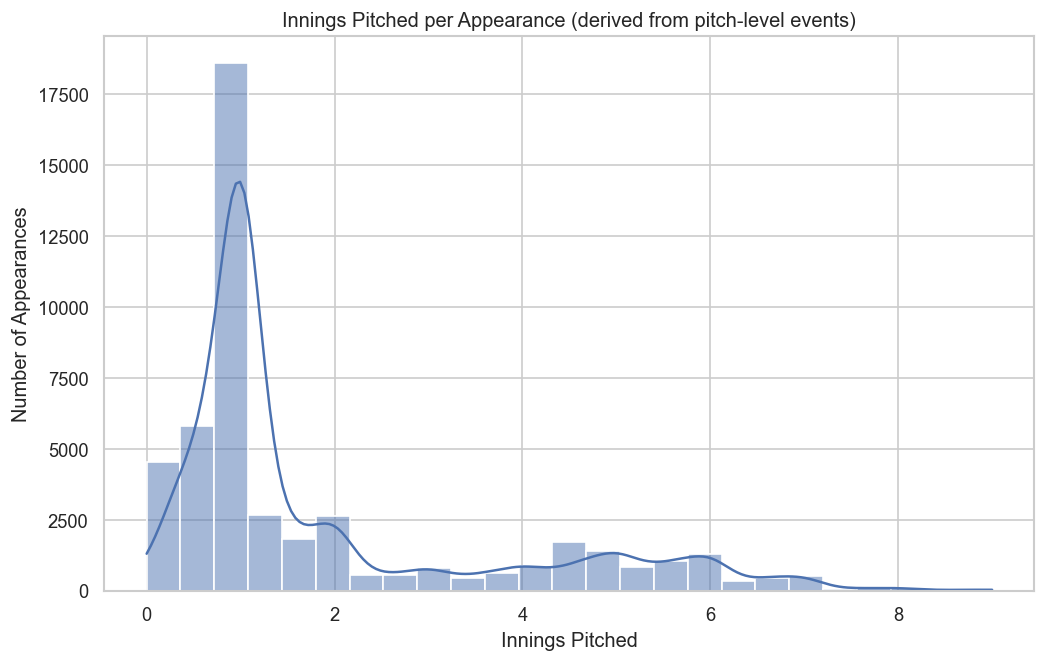

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(pitcher_appear['innings_before_pull'].dropna(), bins=25, kde=True)
plt.title("Innings Pitched per Appearance (derived from pitch-level events)")
plt.xlabel("Innings Pitched")
plt.ylabel("Number of Appearances")
plt.savefig(os.path.join(viz_folder, "innings_pitched_hist.png"), dpi=300, bbox_inches="tight")
plt.show()

## 7. Pitch count distribution (hist)

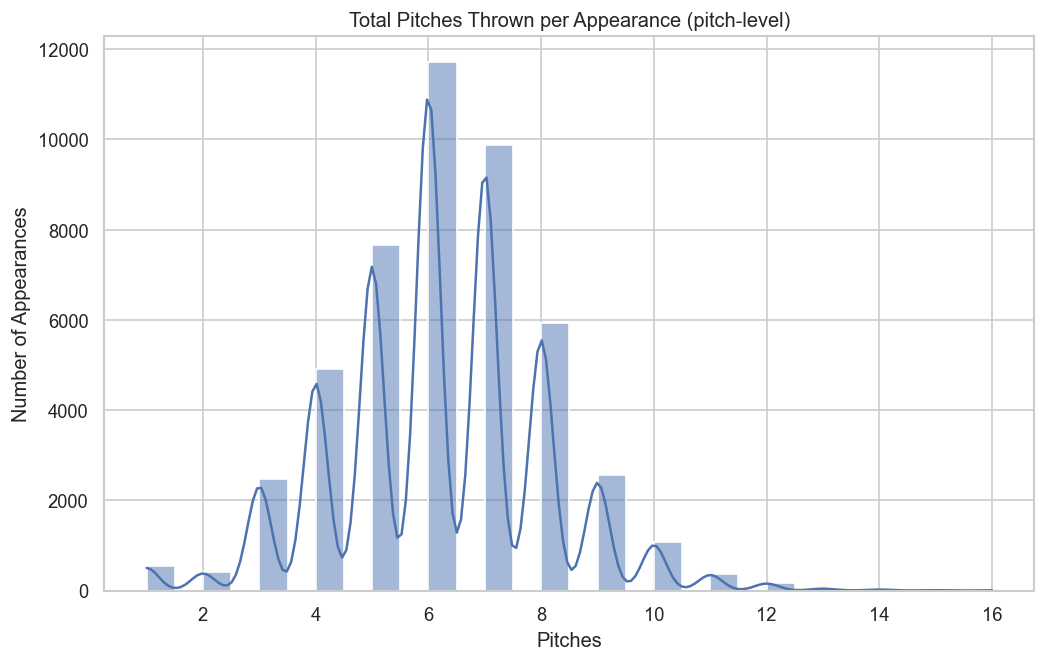

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(pitcher_appear['total_pitches'].dropna(), bins=30, kde=True)
plt.title("Total Pitches Thrown per Appearance (pitch-level)")
plt.xlabel("Pitches")
plt.ylabel("Number of Appearances")
plt.savefig(os.path.join(viz_folder, "pitches_per_game_hist.png"), dpi=300, bbox_inches="tight")
plt.show()

## 8. Overlay — Pitch count distribution (All vs Low-Inning)

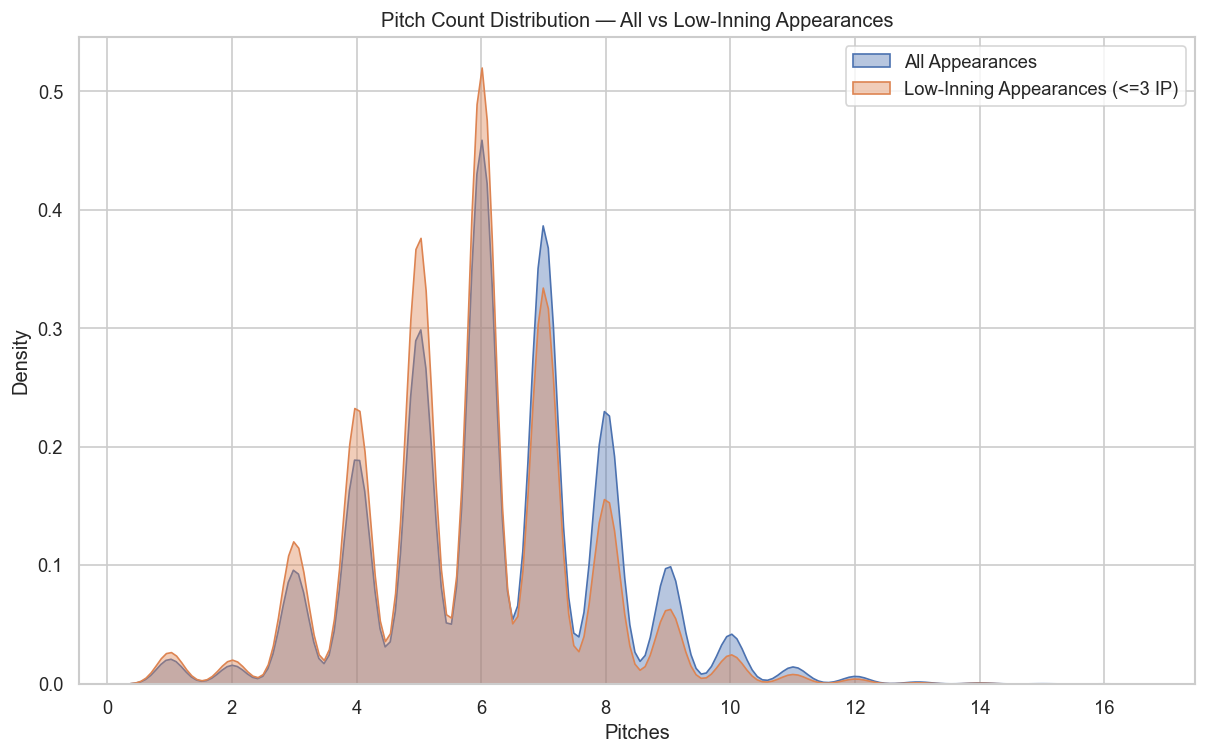

In [39]:
# Low-inning subset (≤3 innings)
low_innings = pitcher_appear[pitcher_appear['innings_before_pull'] <= 3]

plt.figure(figsize=(12,7))
sns.kdeplot(pitcher_appear['total_pitches'].dropna(), label='All Appearances', fill=True, alpha=0.4)
sns.kdeplot(low_innings['total_pitches'].dropna(), label='Low-Inning Appearances (<=3 IP)', fill=True, alpha=0.4)
plt.legend()
plt.title("Pitch Count Distribution — All vs Low-Inning Appearances")
plt.xlabel("Pitches")
plt.savefig(os.path.join(viz_folder, "pitchcount_lowinning_overlay.png"), dpi=300, bbox_inches="tight")
plt.show()

## 9. Innings vs Pitch count scatter for low-inning appearances

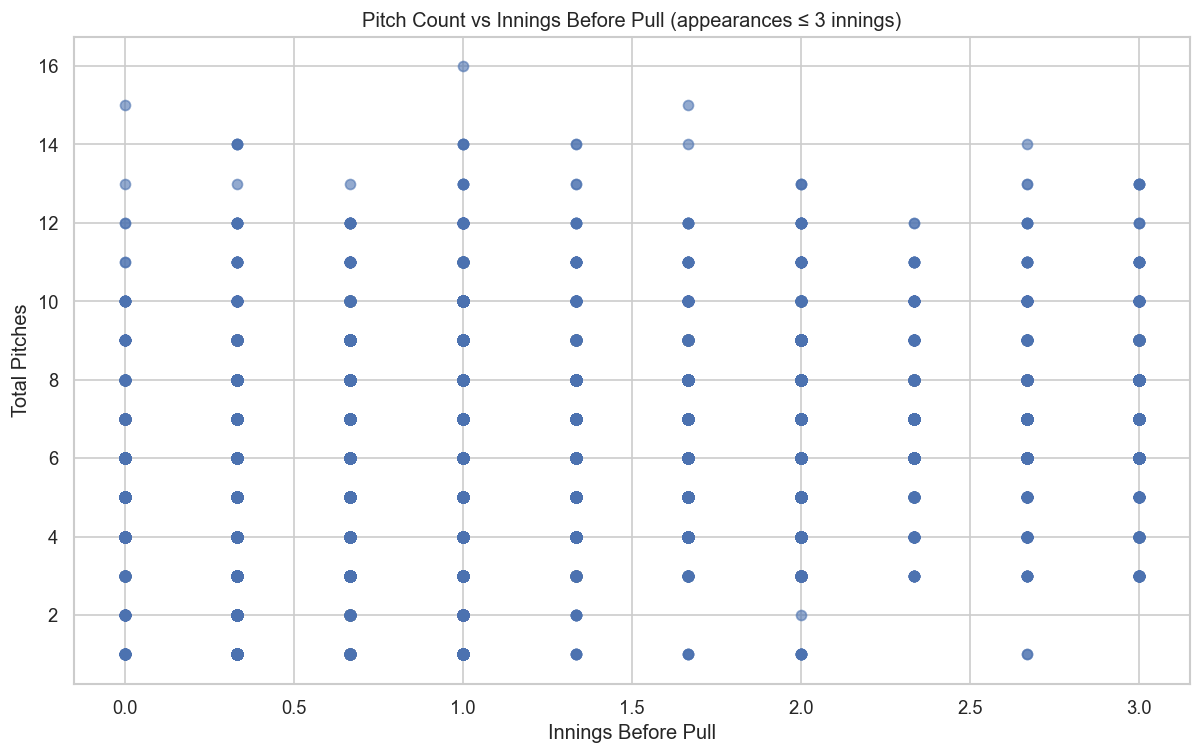

In [40]:
plt.figure(figsize=(12,7))
plt.scatter(low_innings['innings_before_pull'], low_innings['total_pitches'], alpha=0.6)
plt.title("Pitch Count vs Innings Before Pull (appearances ≤ 3 innings)")
plt.xlabel("Innings Before Pull")
plt.ylabel("Total Pitches")
plt.grid(True)
plt.savefig(os.path.join(viz_folder, "lowinnings_pitchcount_scatter.png"), dpi=300, bbox_inches="tight")
plt.show()

## 10. TTO Distribution using pitch-level n_thruorder_pitcher

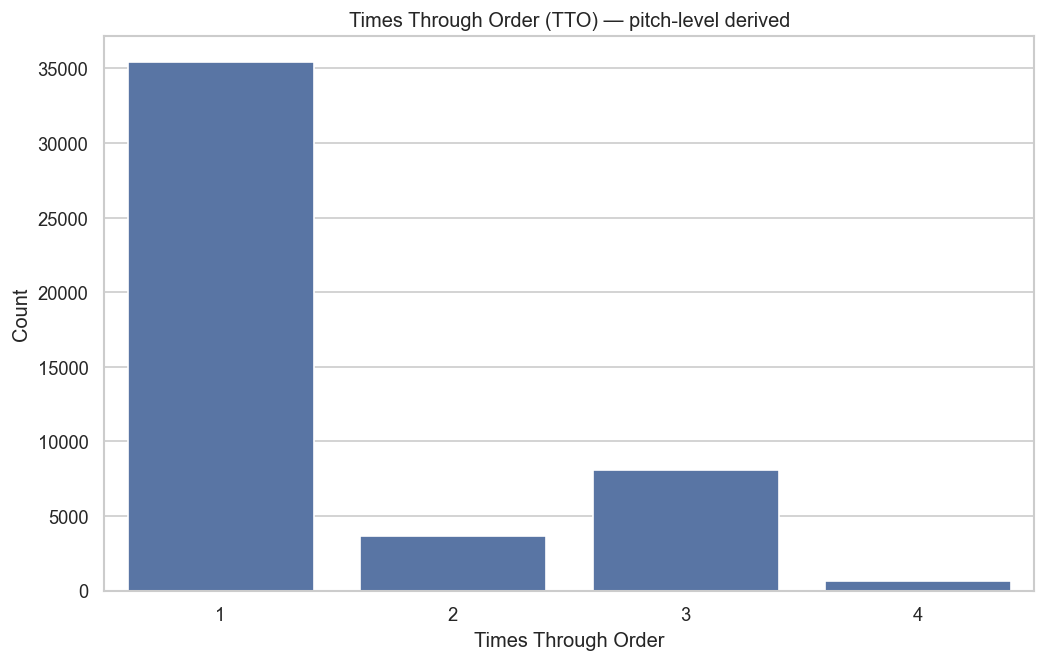

In [41]:
plt.figure(figsize=(10,6))
if 'tto_max' in pitcher_appear.columns:
    sns.countplot(x=pitcher_appear['tto_max'].dropna().astype(int))
    plt.title("Times Through Order (TTO) — pitch-level derived")
    plt.xlabel("Times Through Order")
    plt.ylabel("Count")
    plt.savefig(os.path.join(viz_folder, "tto_distribution.png"), dpi=300, bbox_inches="tight")
else:
    plt.text(0.1, 0.5, "n_thruorder_pitcher not available", fontsize=14)
plt.show()

## 11. Release speed distribution & ridge by pitch type

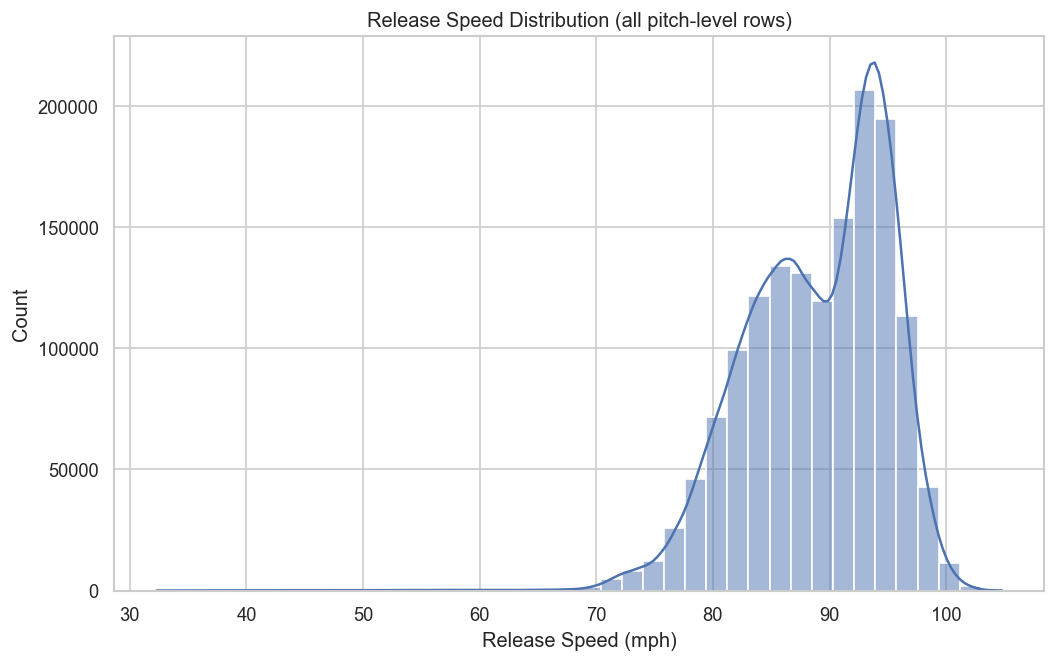

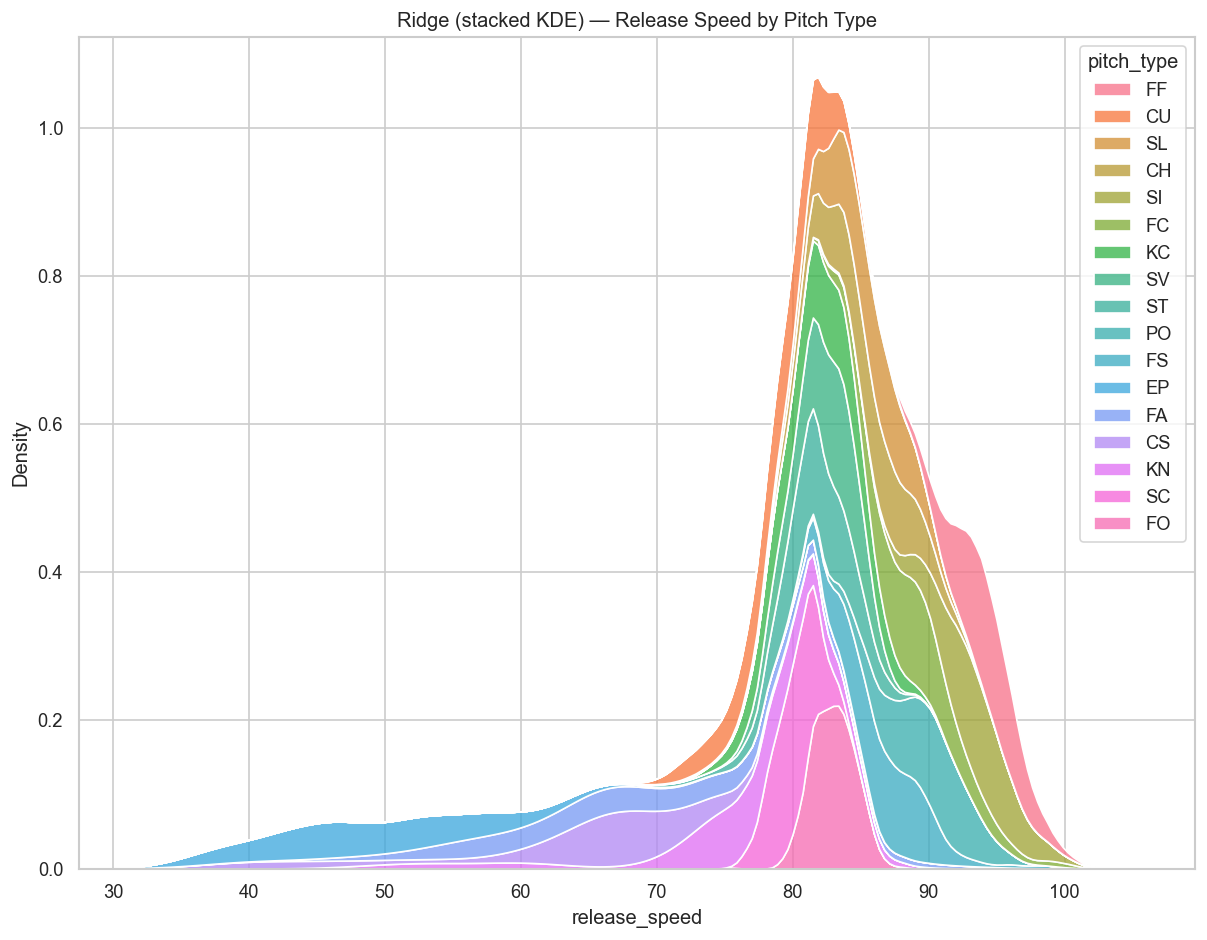

In [42]:
# Overall release speed distribution
plt.figure(figsize=(10,6))
sns.histplot(df[RELEASE_SPEED_COL].dropna(), bins=40, kde=True)
plt.title("Release Speed Distribution (all pitch-level rows)")
plt.xlabel("Release Speed (mph)")
plt.savefig(os.path.join(viz_folder, "release_speed_hist.png"), dpi=300, bbox_inches="tight")
plt.show()

# Ridge plot-style KDE of release speed by pitch type (stacked)
plt.figure(figsize=(12,9))
sns.kdeplot(data=df, x=RELEASE_SPEED_COL, hue=PITCH_TYPE_COL, multiple="stack", common_norm=False)
plt.title("Ridge (stacked KDE) — Release Speed by Pitch Type")
plt.savefig(os.path.join(viz_folder, "ridge_speed_by_pitchtype.png"), dpi=300, bbox_inches="tight")
plt.show()

## 12. Pitch-type distribution (appearance-weighted or pitch-weighted)

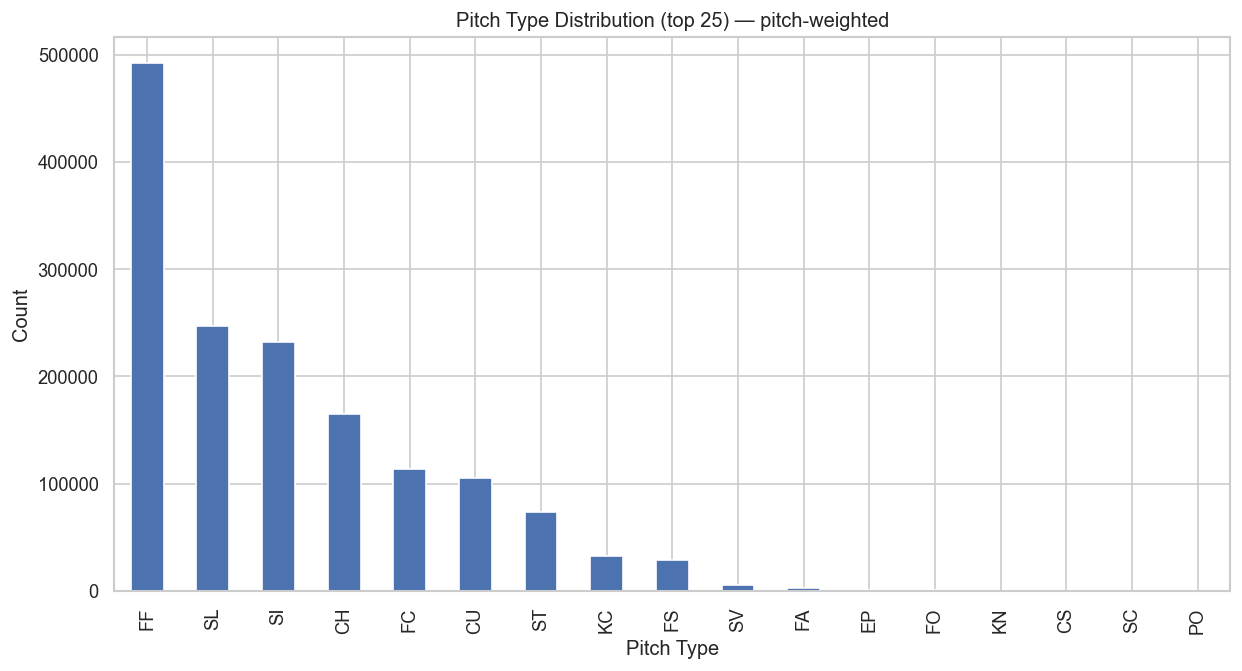

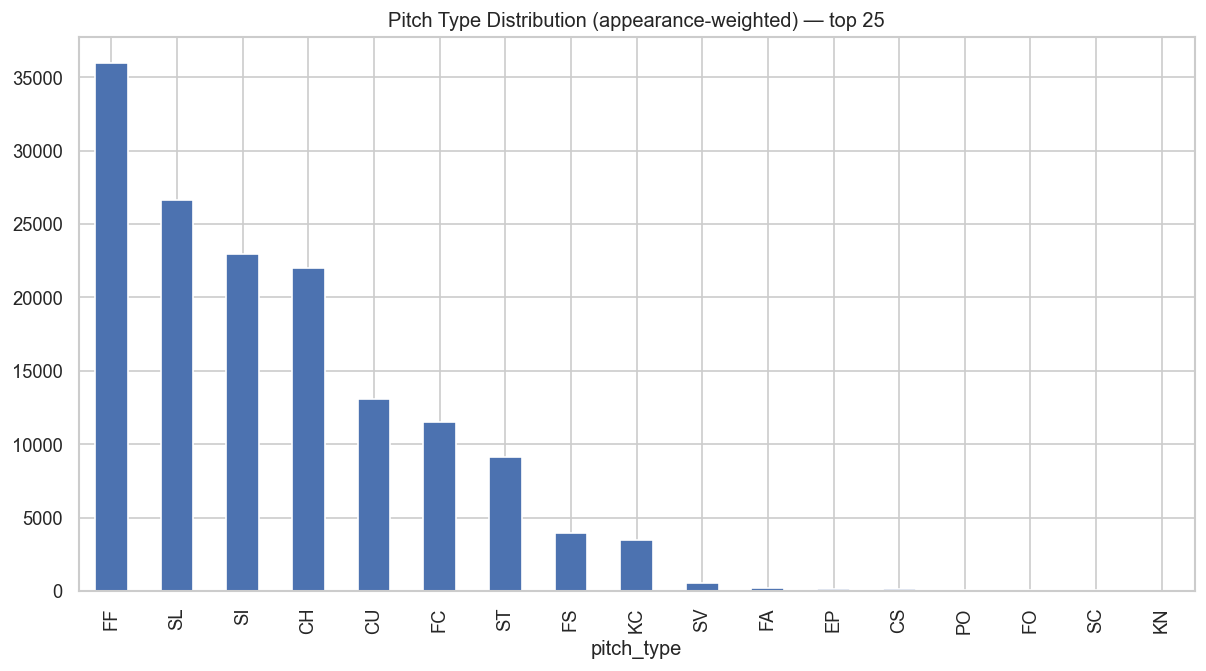

In [43]:
# Pitch-weighted (counts of each pitch row)
plt.figure(figsize=(12,6))
df[PITCH_TYPE_COL].value_counts().head(25).plot(kind='bar')
plt.title("Pitch Type Distribution (top 25) — pitch-weighted")
plt.xlabel("Pitch Type")
plt.ylabel("Count")
plt.savefig(os.path.join(viz_folder, "pitch_type_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()

# Appearance-weighted: count distinct pitcher-game uses of each pitch type
appearance_pitch_type = df.groupby([GAME_COL, PITCHER_COL])[PITCH_TYPE_COL].unique().explode().value_counts()
plt.figure(figsize=(12,6))
appearance_pitch_type.head(25).plot(kind='bar')
plt.title("Pitch Type Distribution (appearance-weighted) — top 25")
plt.savefig(os.path.join(viz_folder, "pitch_type_appearance_weighted.png"), dpi=300, bbox_inches="tight")
plt.show()

## 13. Pitcher × Pitch Type heatmap (large fig)

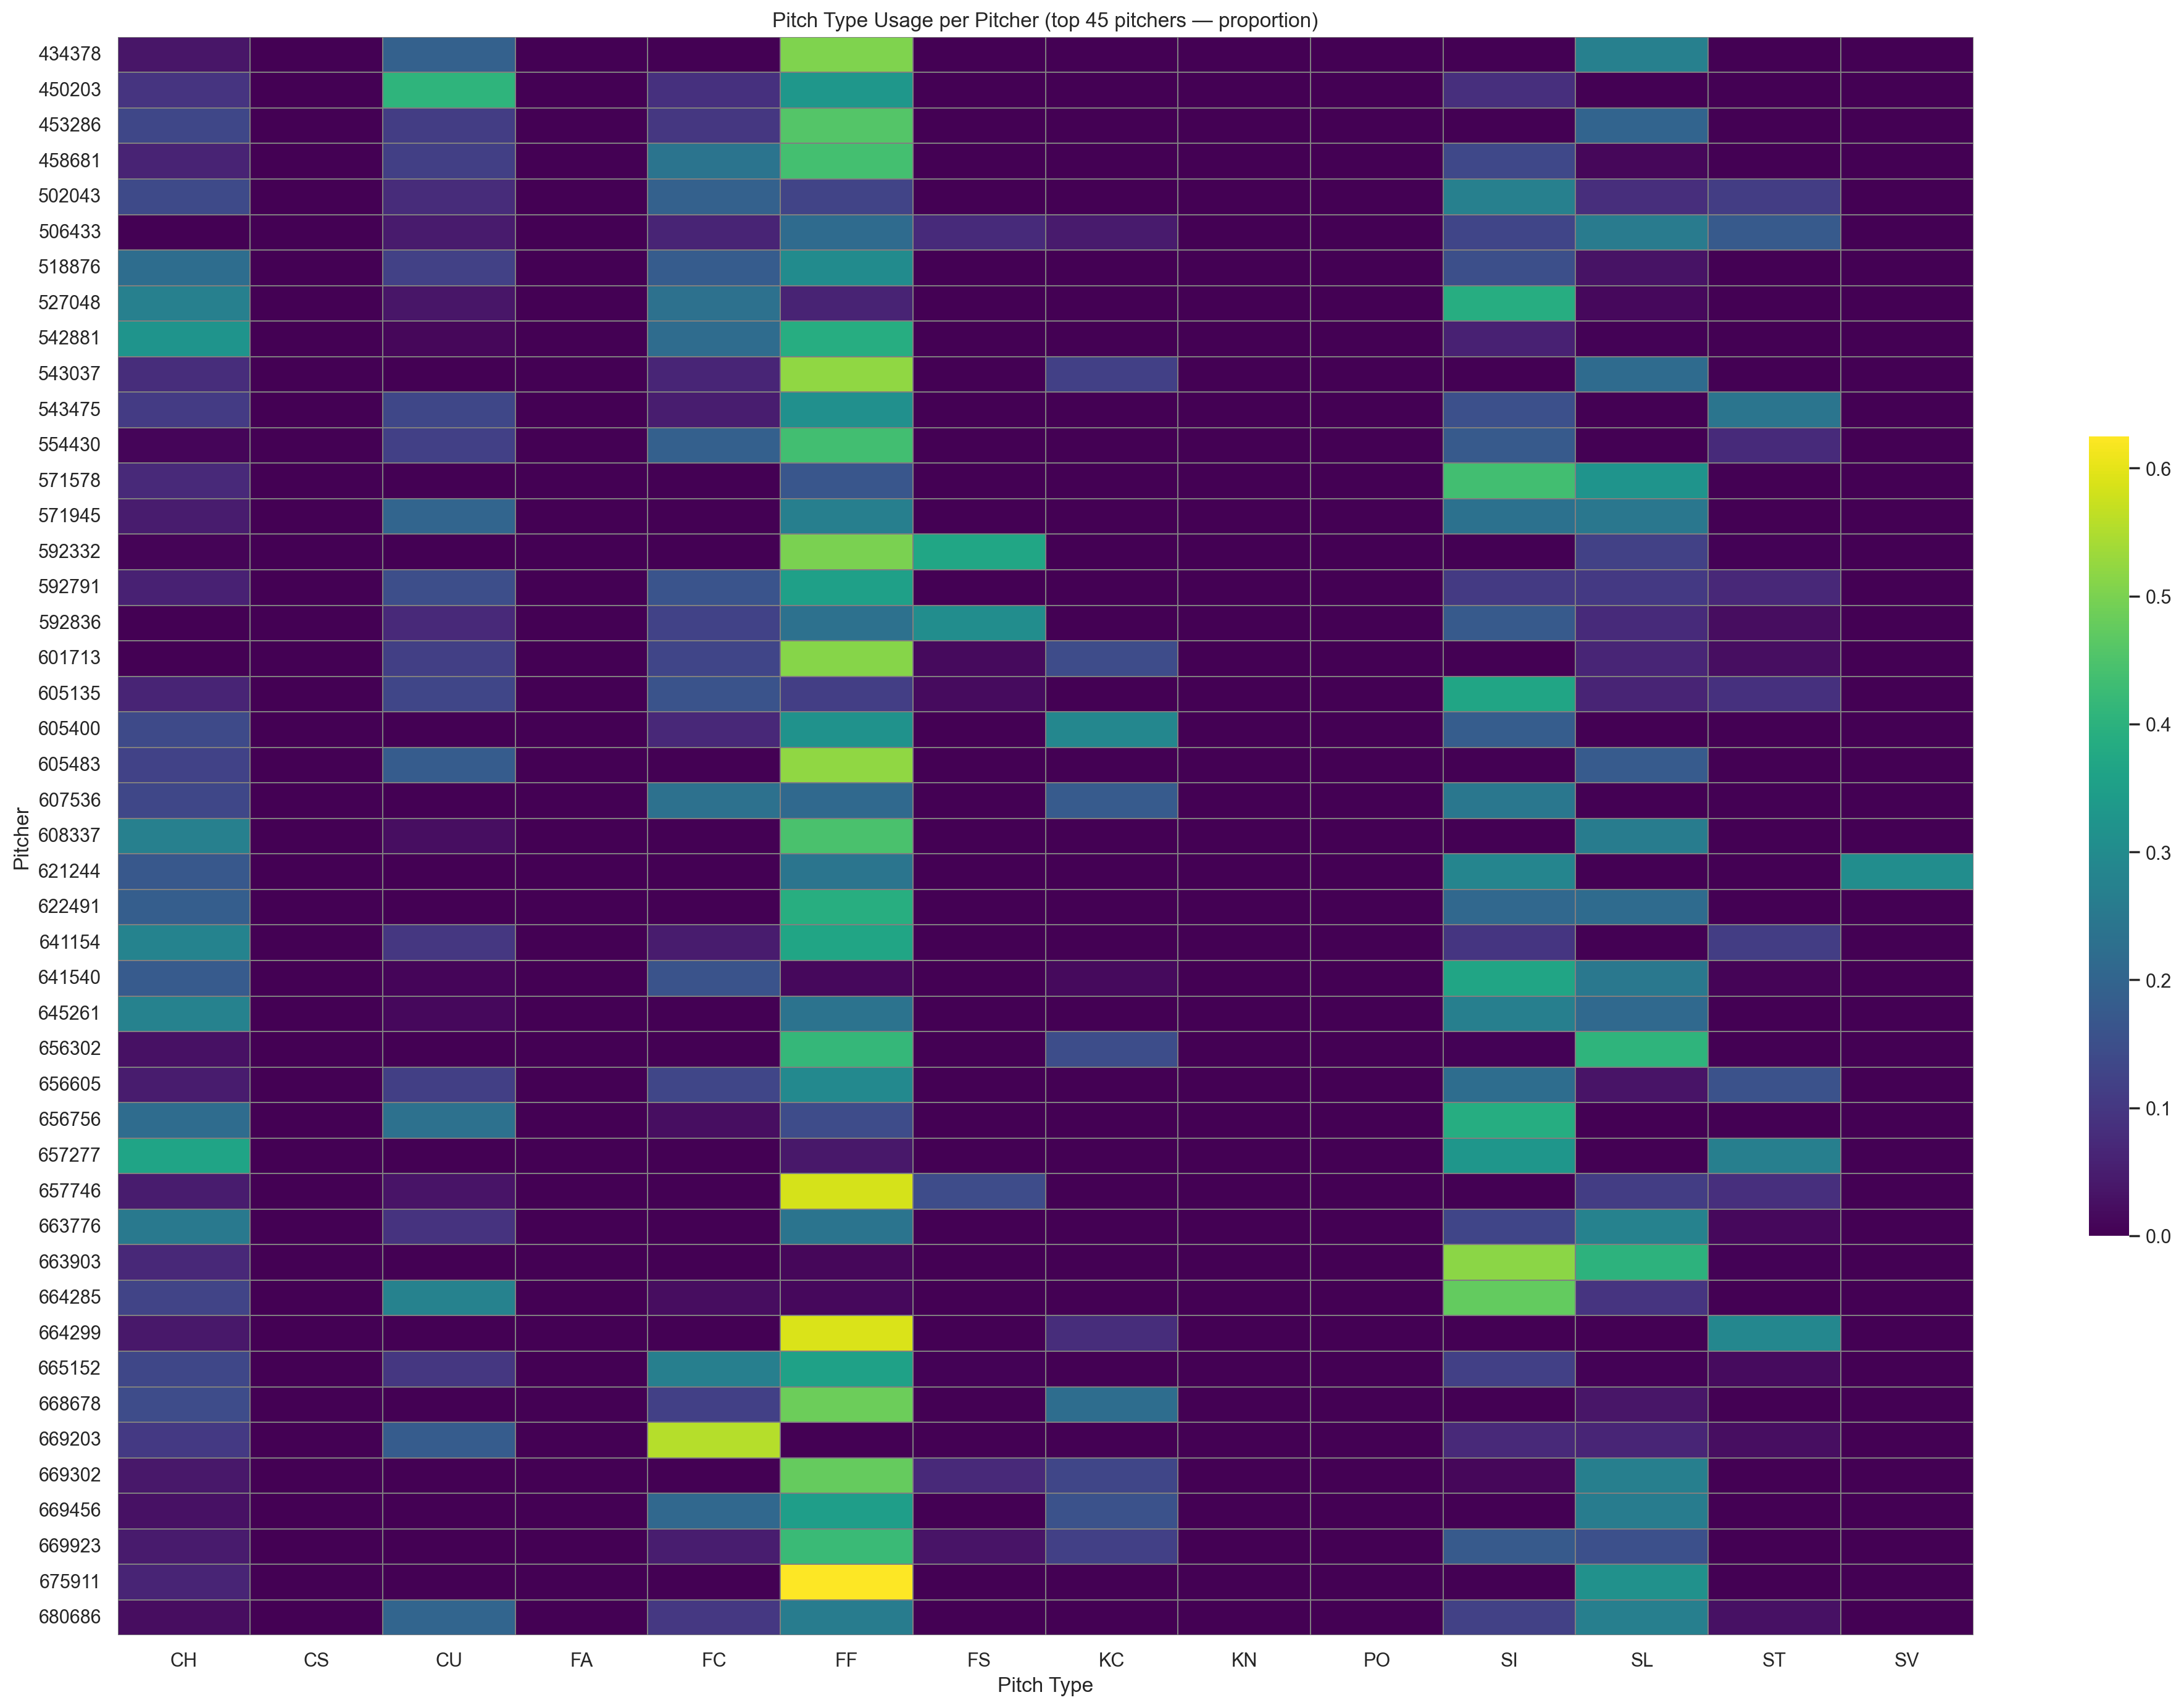

In [44]:
# Build pivot for top N pitchers (by number of pitches) to keep heatmap readable
top_n = 45
top_pitchers = df[PITCHER_COL].value_counts().nlargest(top_n).index
pivot = pd.crosstab(df[df[PITCHER_COL].isin(top_pitchers)][PITCHER_COL], df[PITCH_TYPE_COL])

# Normalize per pitcher (proportion of repertoire)
pivot_norm = pivot.div(pivot.sum(axis=1).replace(0,1), axis=0)

plt.figure(figsize=(20,14), dpi=200)
sns.heatmap(pivot_norm, cmap="viridis", linewidths=0.15, linecolor='gray', cbar_kws={"shrink":0.5})
plt.title(f"Pitch Type Usage per Pitcher (top {top_n} pitchers — proportion)")
plt.xlabel("Pitch Type")
plt.ylabel("Pitcher")
plt.tight_layout()
plt.savefig(os.path.join(viz_folder, "pitcher_pitchtype_heatmap_large.png"), dpi=300, bbox_inches="tight")
plt.show()

## 14. Correlation heatmap (numeric features)

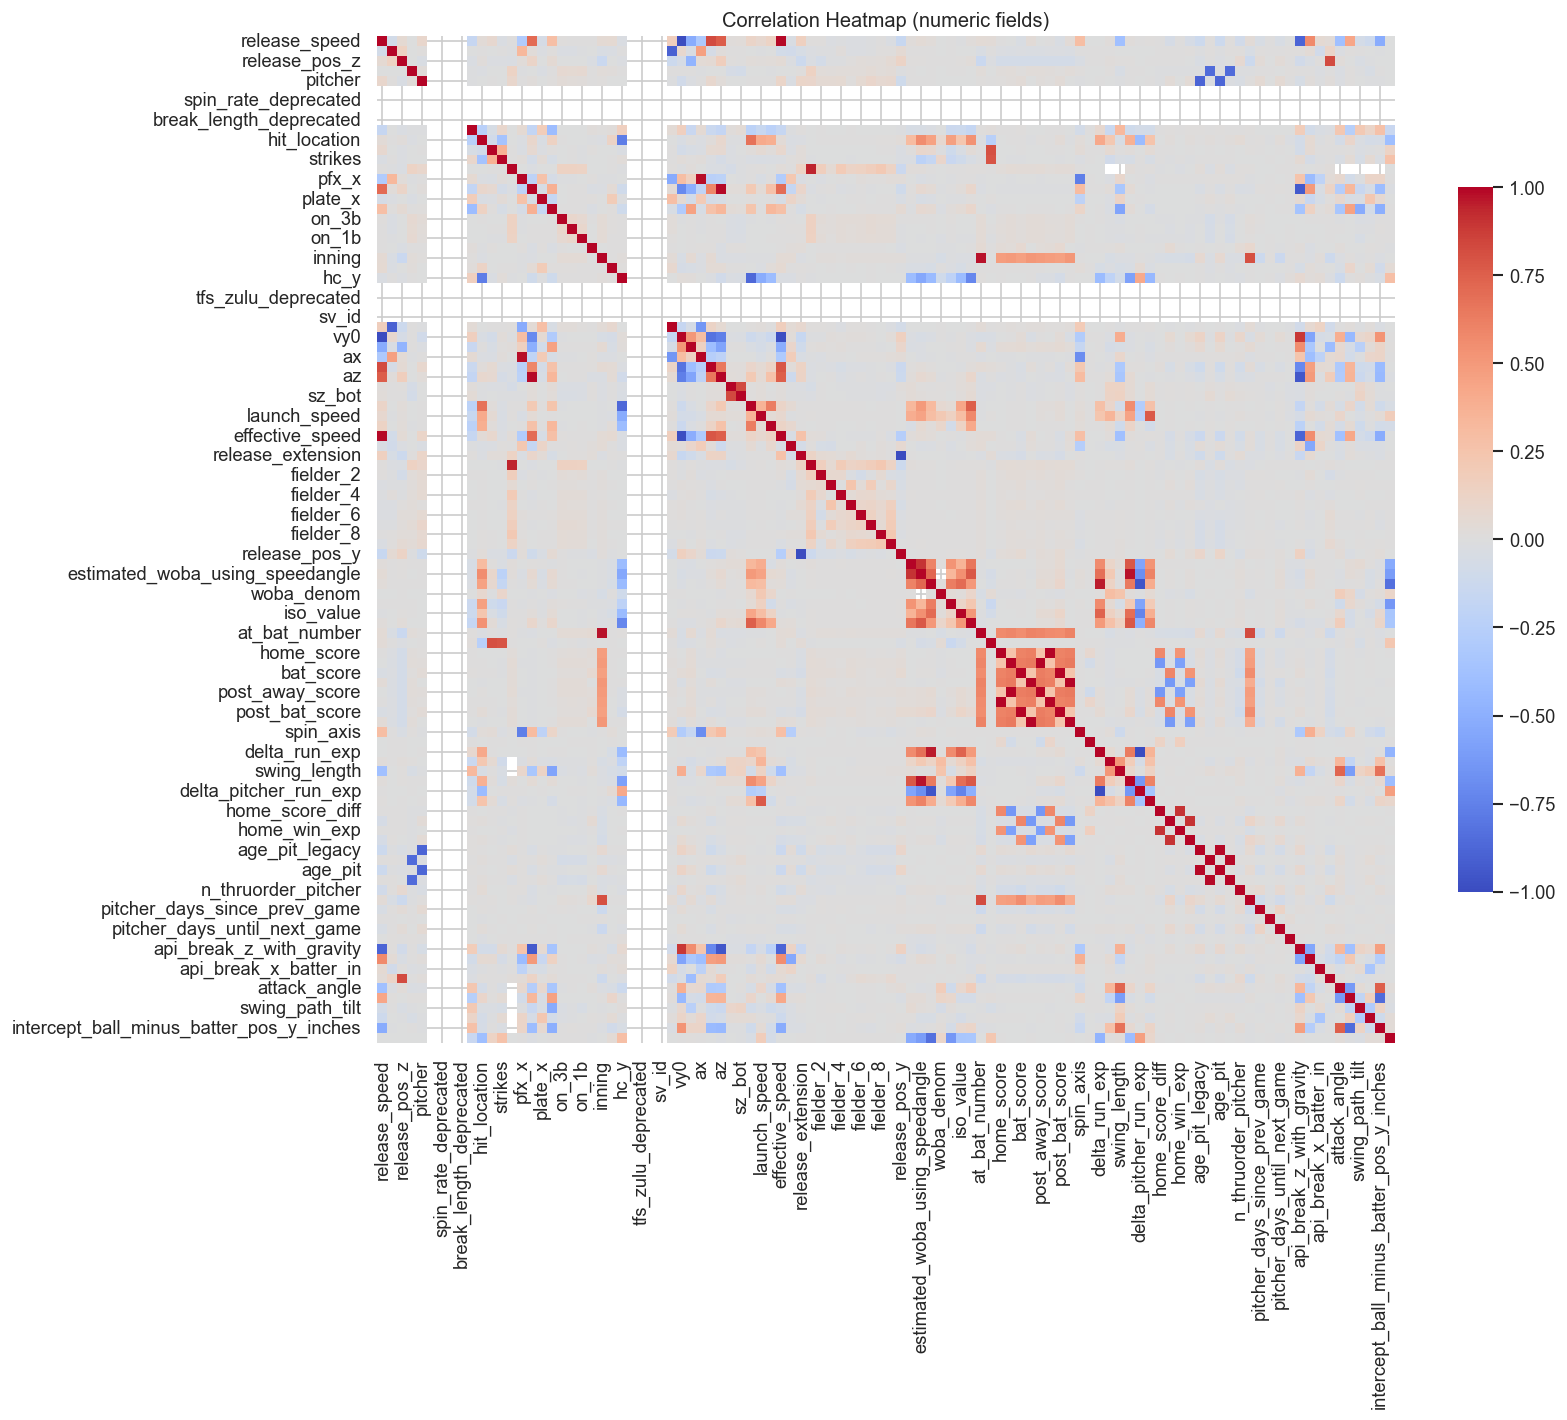

In [45]:
plt.figure(figsize=(14,12))
num_corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(num_corr, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={"shrink":0.7})
plt.title("Correlation Heatmap (numeric fields)")
plt.tight_layout()
plt.savefig(os.path.join(viz_folder, "correlation_heatmap_numeric.png"), dpi=300, bbox_inches="tight")
plt.show()

## Example pitcher profiles

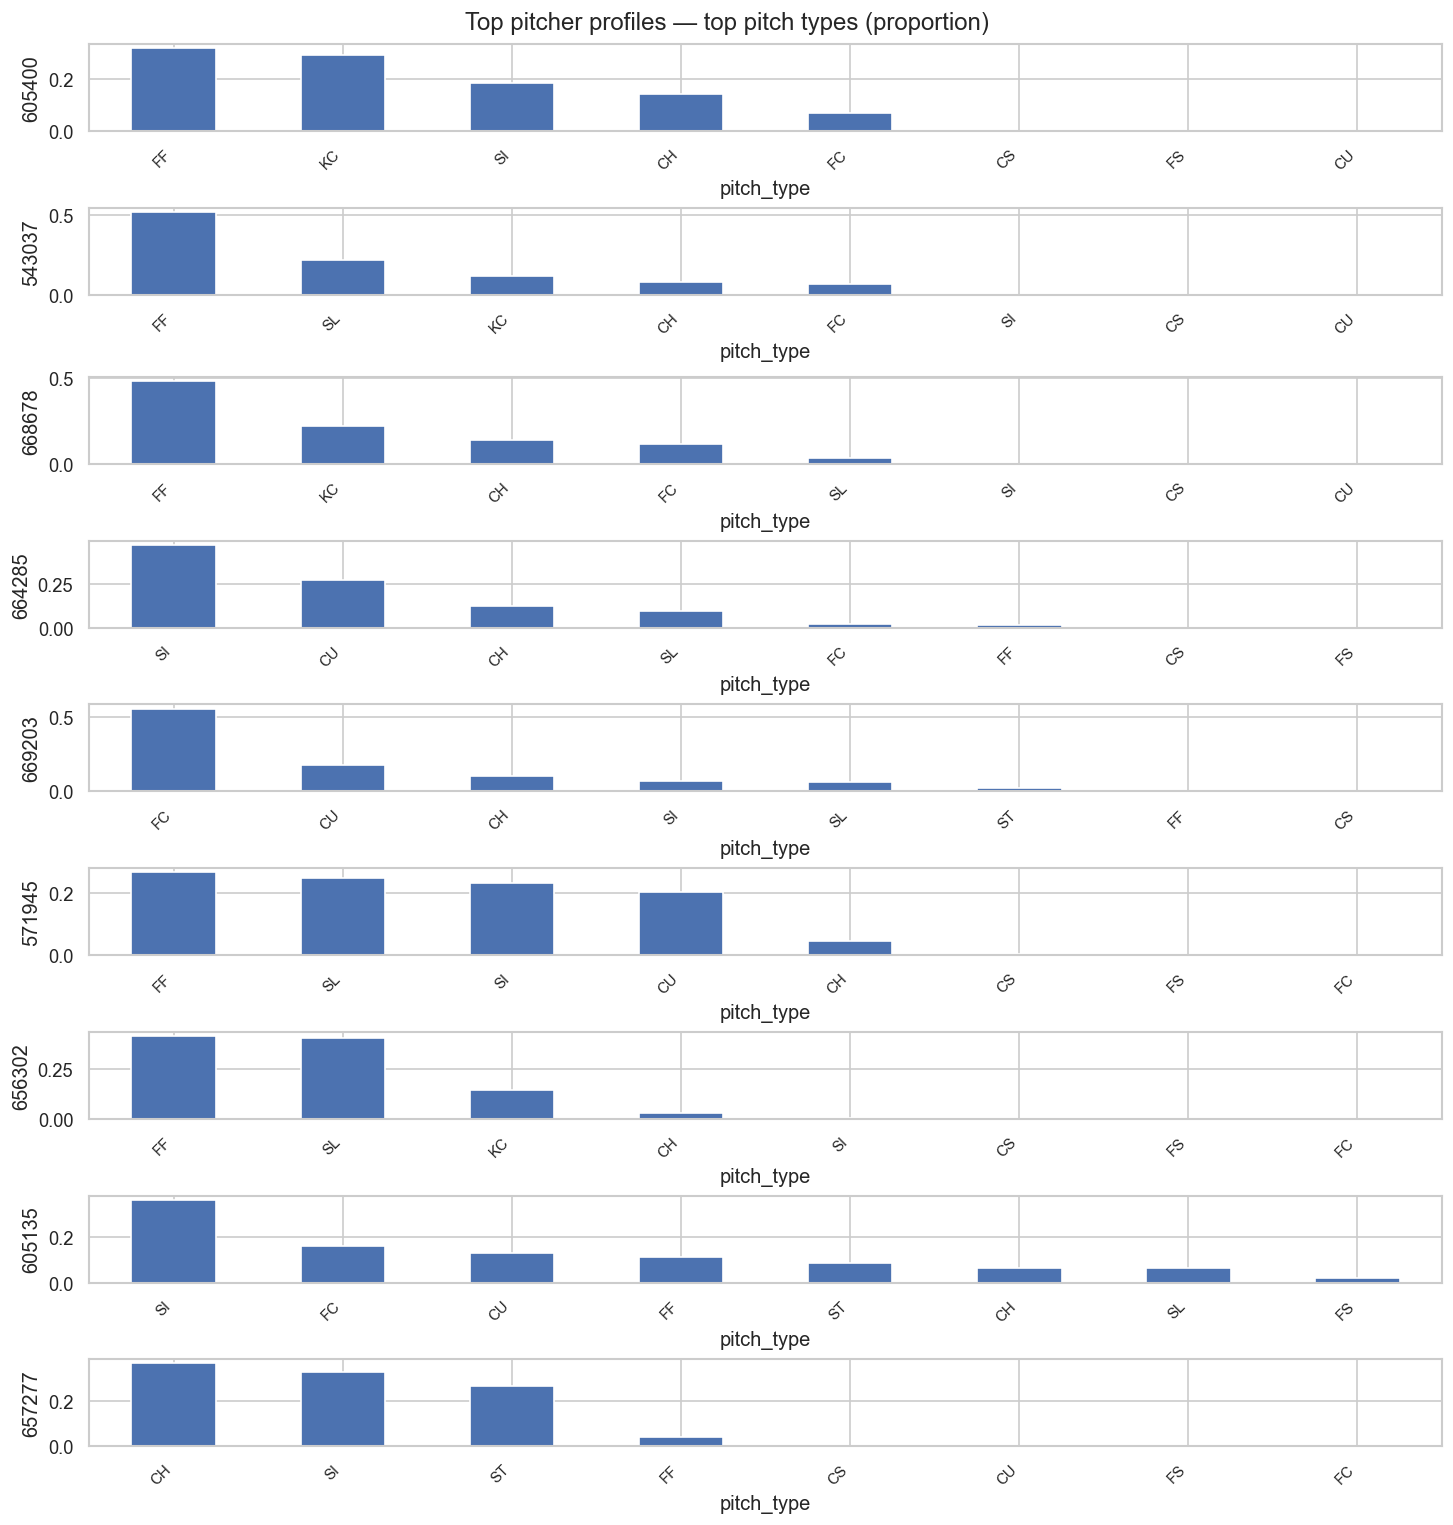

In [46]:
# Build a small-multiples faceted display for top pitchers
profiles_n = 9
top_profiles = df[PITCHER_COL].value_counts().nlargest(profiles_n).index.tolist()
profile_df = df[df[PITCHER_COL].isin(top_profiles)].copy()

# For each pitcher, plot stacked bar of pitch-type proportions and mean velocity
agg = profile_df.groupby([PITCHER_COL, PITCH_TYPE_COL]).size().unstack(fill_value=0)
agg_prop = agg.div(agg.sum(axis=1), axis=0)

fig, axes = plt.subplots(nrows=profiles_n, ncols=1, figsize=(12, profiles_n*1.4), constrained_layout=True)
for i, pitcher in enumerate(top_profiles):
    ax = axes[i]
    row = agg_prop.loc[pitcher].sort_values(ascending=False)
    row.head(8).plot(kind='bar', ax=ax)
    ax.set_ylabel(pitcher)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
fig.suptitle("Top pitcher profiles — top pitch types (proportion)")
plt.savefig(os.path.join(viz_folder, "top_pitcher_profiles.png"), dpi=300, bbox_inches="tight")
plt.show()

## Short analysis snippets / quick tables

In [47]:
# Summary table: distribution of innings (counts)
print("Innings pitched distribution (appearance-level):")
print(pitcher_appear['innings_before_pull'].value_counts().sort_index())

# Show examples of low-inning & low-pitch (<=3 innings and <=30 pitches)
candidates = pitcher_appear[(pitcher_appear['innings_before_pull'] <= 3) & (pitcher_appear['total_pitches'] <= 30)]
print("\nSample low-inning low-pitch appearances (first 10):")
candidates.head(10)

Innings pitched distribution (appearance-level):
innings_before_pull
0.000000      793
0.333333     3752
0.666667     5808
1.000000    18620
1.333333     2670
1.666667     1804
2.000000     2625
2.333333      560
2.666667      549
3.000000      796
3.333333      451
3.666667      625
4.000000      860
4.333333      661
4.666667     1035
5.000000     1385
5.333333      817
5.666667     1024
6.000000     1282
6.333333      331
6.666667      458
7.000000      505
7.333333       64
7.666667       78
8.000000       91
8.333333       16
8.666667       19
9.000000       31
Name: count, dtype: int64

Sample low-inning low-pitch appearances (first 10):


,game_pk,pitcher_id,outs_recorded_in_appearance,innings_before_pull,total_pitches,bat_score_diff_end,tto_max,pitcher_throws,avg_release_speed,most_common_pitch
0,661032,543238,2,0.666667,6,4,1,L,91.271429,FF
1,661032,571901,3,1.000000,6,-4,1,L,89.44,SI
2,661032,623474,1,0.333333,5,-4,1,R,84.9,SI
3,661032,628452,2,0.666667,5,-3,1,R,87.577778,FF
4,661032,660853,4,1.333333,7,4,1,R,91.991667,FF
7,661033,571901,2,0.666667,9,-3,1,L,88.194737,SI
8,661033,595939,0,0.000000,6,2,1,R,88.014286,FF
9,661033,605151,3,1.000000,5,-1,1,R,86.45,CH
10,661033,623474,3,1.000000,6,-1,1,R,85.45,SI
11,661033,642585,4,1.333333,9,0,1,R,95.771429,SI


## Appendix: mapping of events used to detect outs

### Appendix: event → outs mapping used
The notebook used a conservative event keyword mapping to assign outs:
- Double-play keywords (double play) → 2 outs
- Single-out keywords (strikeout, groundout, flyout, lineout, pop out, force out, field out, etc.) → 1 out
- Triple play (rare) → 3 outs
- All other events → 0 outs

This approach is conservative and robust across Statcast event naming conventions. If a more exact encoding is desired, the event list can be expanded to mirror a canonical mapping (e.g., mapping specific `events` values to exact outs).